In [18]:
#winner
import torch, torch.nn as nn
import numpy as np
from egnn_pytorch import EGNN
from architecture import (StackedEGNN,
                          LearnableRBF,
                          AttentionBlock,
                          TunableBlock)
import time, datetime
import glob
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import random, os, numpy as np, torch, glob, datetime
from torch.cuda.amp import GradScaler, autocast

torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False


class Cfg(dict):
    # ================================================================
    # 0) dashboard – flip anything here
    # ================================================================
    __getattr__ = dict.__getitem__; __setattr__ = dict.__setitem__


# ================================================================
# 2) dataset helpers
# ================================================================
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader

# ================================================================
# 3) model
# ================================================================

class Model(nn.Module):
    "without knn = perm variant"
    def __init__(self,c):
        super().__init__(); self.c=c
        inner_dim = c.dim + c.basis

        self.egnn = StackedEGNN(c.dim,c.depth,c.hidden_dim,c.dropout,
                                c.hood_k,98,c.num_neighbors,c.norm_coors).to(c.device)

        self.rbf  = TunableBlock(LearnableRBF(c.basis,10.).to(c.device), c.use_rbf)
        self.attn = TunableBlock(AttentionBlock(inner_dim,inner_dim,c.hidden_dim).to(c.device), c.use_attn)

        if c.aggregator=='linear':
            self.agg = nn.Linear(inner_dim,1).to(c.device)
        elif c.aggregator=='nconv':
            self.agg = nn.Conv1d(c.hood_k,1,kernel_size=inner_dim,padding=0).to(c.device)
        elif c.aggregator=='pool':
            self.agg = None
        else: raise ValueError("aggregator must be 'linear' | 'nconv' | 'pool'")

        #
        self.boost = nn.Linear(1,1).to(c.device) if c.use_boost else nn.Identity()
        self.prot  = EGNN(dim=1,update_coors=True,norm_coors=True, norm_feats=True, 
                          num_nearest_neighbors=c.pegnn_radius).to(c.device) \
                     if c.use_prot else nn.Identity()
        self.rconv  = nn.Conv1d(1,1,c.conv_kernel,padding=c.conv_kernel//2).to(c.device) \
                     if c.use_conv else nn.Identity()

    def forward(self,z,x):
        h,coord=self.egnn(z,x); h=h[0]                # (R,N,dim)
        cent=coord.mean(1,keepdim=True)               # (R,1,3)

        # --- build token ----------------------------------------------------------------
        r = self.rbf(cent,coord).transpose(1,2) if self.c.use_rbf else \
            h.new_zeros(h.size(0),self.c.basis,self.c.hood_k)
        tok = torch.cat((r,h.transpose(1,2)),dim=1)       # (R,C,N)

        att = self.attn(tok.permute(2,0,1))
        tok = att[0] if isinstance(att,(tuple,list)) else att
        tok = tok.permute(1,0,2)                      # (R,N,C)

        # --- aggregation ----------------------------------------------------------------
        if self.c.aggregator=='linear':
            preds = self.agg(tok) .max(1).values                # (R,1)
        elif self.c.aggregator=='nconv':
            preds = self.agg(tok).squeeze(-1)                   # (R,1)
        else:   # pool
            preds = tok.max(1).values.mean(1,keepdim=True)      # (R,1)

        preds = self.boost(preds)

        if self.c.use_prot:
            preds = self.prot(preds.unsqueeze(0),
                              cent.permute(1,0,2))[0].squeeze(0)

        if self.c.use_conv:
            preds = self.rconv(preds.T.unsqueeze(0)).squeeze(0).T

        return preds
    
class HoodDS(Dataset):
    """Generate hoods around n_neighbors, a hyperparameter. This choice determines how many n_nearest neighbors
    the egnn encoder sees.
    
    This function takes as input the pdb.npz numpy files and returns an """
    def __init__(self, paths, keep_ids=False):
        self.data=[]; self.ids=[];self.keep_ids = keep_ids; 
        nbr=NearestNeighbors(n_neighbors=cfg.hood_k,algorithm='brute')
        for p in paths:
            try:
                d=np.load(p,allow_pickle=True)
                if len(d['sites'])==0: continue
                nbr.fit(d['pos']); idx=nbr.kneighbors(d['sites'],return_distance=False)
                self.data.append((torch.from_numpy(d['z'][idx]),
                                  torch.from_numpy(d['pos'][idx]),
                                  torch.from_numpy(d['pks'])))
                self.ids.append(os.path.splitext(os.path.basename(p))[0])
            except Exception as e: print("skip",p,e)
    def __len__(self): return len(self.data)
    def __getitem__(self,i):
        z,p,y=self.data[i]; 
        return z,p,y,self.ids[i] if self.keep_ids else z,p,y

    def pad(batch,k,device,keep_ids=False):
        ids=[b[3] for b in batch] if keep_ids else None
        B=len(batch); S=max(b[0].shape[0] for b in batch)
        zt=torch.zeros(B,S,k,dtype=torch.int32,device=device)
        pt=torch.zeros(B,S,k,3,dtype=torch.float32,device=device)
        yt=torch.full((B,S),float('nan'),device=device); mt=torch.zeros(B,S,dtype=torch.bool,device=device)
        for b,data in enumerate(batch):
            z,p,y=data[0],data[1],data[2]
            s=z.shape[0]; zt[b,:s]=z; pt[b,:s]=p; yt[b,:s]=y; mt[b,:s]=True
        return (zt,pt,yt,mt,data[3]) if keep_ids else (zt,pt,yt,mt)

    def split(paths):
        """deterministic and random"""
        if cfg.num_paths: paths=paths[:cfg.num_paths]
        #rng=np.random.RandomState(cfg.split_seed)
        #idx=rng.permutation(len(paths)); cut=int(len(paths)*cfg.split_ratio)
        cut=1
        idx=[0,1,2]
        return [paths[i] for i in idx[:cut]], [paths[i] for i in idx[cut:]]

t0=time.time()
cfg = Cfg(
    # backbone
    INPUTS_DIR="../../../data/pkegnn_INS/inputs/*.npz",
    dim=6, basis=6, depth=2, hidden_dim=4, dropout=0.00,
    hood_k=100, num_neighbors=11, norm_coors=True,

    epochs=1, num_paths=3,

    # aggregation: 'linear' | 'nconv' | 'pool'
    aggregator   ='linear',

    # block switches
    use_rbf      =True,
    use_attn     =True,
    use_boost    =True,     # Linear(1→1) after aggregator
    use_prot     =True,      # protein‑level EGNN
    use_conv     =True,     # 1‑D conv after prot EGNN
    conv_kernel  =7,
    pegnn_radius=8, #so no idx error

    # training
    loss_type='mse',
    study_metrics=True,
    lr=5e-3, batch_size=1, #batchsize not safw to inc

    # misc
    device='cuda' if torch.cuda.is_available() else 'cpu',
    seed=0, analysis_mode=False,
    split_ratio=0.5, split_seed=0,
    runid=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
)
print("Run‑ID:", cfg.runid)
if not cfg.seed=="no seed":
    random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
    # 2) Create a fixed Generator for the train shuffle:
    g = torch.Generator()
    g.manual_seed(cfg.seed)

model=Model(cfg); 
print("params:",sum(p.numel() for p in model.parameters()))



# ================================================================
# 4) loaders
# ================================================================


def run_hoodDS(cfg):
    coll = lambda b: HoodDS.pad(b,cfg.hood_k,cfg.device,cfg.analysis_mode)
    tr,val=HoodDS.split(sorted(glob.glob(cfg.INPUTS_DIR)))
    train_ds=HoodDS(tr,cfg.hood_k); val_ds=HoodDS(val,cfg.hood_k)
    tr_loader=DataLoader(train_ds,batch_size=cfg.batch_size,shuffle=True , generator=g,collate_fn=coll); val_loader=DataLoader(val_ds,batch_size=cfg.batch_size,shuffle=False,collate_fn=coll)
    return tr_loader, val_loader


# ================================================================
# 5) training utils
# ================================================================
tr_loader, va_loader=run_hoodDS(cfg)
p_fn = nn.L1Loss() if cfg.loss_type=='mae' else nn.MSELoss()
v_fn = nn.MSELoss() if cfg.loss_type=='mae' else nn.L1Loss()
opt  = torch.optim.AdamW(model.parameters(),lr=cfg.lr)
sch  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=0,cooldown=0,min_lr=1e-16)
scaler=GradScaler(enabled=(cfg.device=='cuda'))

def run(cfg, loader,train):
    model.train() if train else model.eval(); loss_sum=0;n=0;oloss_sum=0
    for z,x,y,m,*_ in loader:
        v=m.view(-1); z=z.view(-1,z.size(2))[v].to(cfg.device)
        x=x.view(-1,x.size(2),3)[v].to(cfg.device); y=y.view(-1)[v].to(cfg.device)
        with autocast(enabled=(cfg.device=='cuda')):
            pred=model(z,x).flatten(); loss=p_fn(pred,y)
        if train:
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        if cfg.study_metrics:
            other_loss = v_fn(pred,y)
            oloss_sum +=other_loss.item(); 
        loss_sum+=loss.item(); n+=1
        
    if not cfg.study_metrics:
        return loss_sum/n
    else:
        return (loss_sum/n, oloss_sum/n)

# ================================================================
# 6) train
# ================================================================
cfg.epochs=10
for e in range(cfg.epochs):
    tr=run(cfg,tr_loader,True)
    va=run(cfg,va_loader,False)
    if not cfg.study_metrics:
        sch.step(va)
        print(f"[{e+1}/{cfg.epochs}]  train {tr:.4f} | val {va:.4f}")
    else:
        sch.step(va[0])
        print(f"[{e+1}/{cfg.epochs}]  train {cfg.loss_type} {tr[0]:.4f} | {cfg.loss_type} val {va[0]:.4f}")
        print("     additional metrics: ",f"[{e+1}/{cfg.epochs}]  train {tr[1]:.4f} | val {va[1]:.4f}")
        print("")

    print(time.time() - t0,"sec")

    ckpt = {
        'model_state': model.state_dict(),
        'optim_state': opt.state_dict(),
        'sched_state': sch.state_dict(),
        'cfg'        : cfg,
    }
    ckpt_name = "ckpt_{}.pt".format(cfg['runid'])
    #torch.save(ckpt, ckpt_name)
    print("Saved checkpoint:", ckpt_name)

    # ---------- run the suite on real inputs -------------------------------------
    print("\n================  INVARIANCE SUITE  ================\n")
    stats = run_invariance_suite(model, tr_loader, cfg,
                                max_batches=3, rot_trials=5,
                                atol=5e-4, rtol=5e-4, verbose=True)

    print("\n----------------  summary (max abs error) ----------------")
    for k,v in stats.items():
        print(f"{k:6}: {v:.3e}")
    print("----------------------------------------------------------")
    print("✔  thresholds used: atol={:.1e}, rtol={:.1e}".format(5e-4,5e-4))
    print("==========================================================\n")



Run‑ID: 20250728_181921
params: 9410


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[1/10]  train mse 2.3795 | mse val 2.7294
     additional metrics:  [1/10]  train 1.2222 | val 1.1900

2.220740556716919 sec
Saved checkpoint: ckpt_20250728_181921.pt

================  INVARIANCE SUITE  ================

[batch 0  rot 0]  max|Δ|=1.788e-07
[batch 0  rot 1]  max|Δ|=3.278e-07
[batch 0  rot 2]  max|Δ|=2.384e-07
[batch 0  rot 3]  max|Δ|=2.682e-07
[batch 0  rot 4]  max|Δ|=5.662e-07
[batch 0  perm‑K ]  max|Δ|=5.273e-02
[batch 0  perm‑R ]  max|Δ|=7.631e-01
-------------------------------------------------------

----------------  summary (max abs error) ----------------
eqv   : 5.662e-07
permK : 5.273e-02
permR : 7.631e-01
----------------------------------------------------------
✔  thresholds used: atol=5.0e-04, rtol=5.0e-04

[2/10]  train mse 2.3056 | mse val 2.7071
     additional metrics:  [2/10]  train 1.2000 | val 1.1780

6.67936897277832 sec
Saved checkpoint: ckpt_20250728_181921.pt

================  INVARIANCE SUITE  ================

[batch 0  rot 0]  max|Δ|=3.129e

In [19]:
#winner
import torch, torch.nn as nn
import numpy as np
from egnn_pytorch import EGNN
from architecture import (StackedEGNN,
                          LearnableRBF,
                          AttentionBlock,
                          TunableBlock)
import time, datetime
import glob
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import random, os, numpy as np, torch, glob, datetime
from torch.cuda.amp import GradScaler, autocast

torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False


class Cfg(dict):
    # ================================================================
    # 0) dashboard – flip anything here
    # ================================================================
    __getattr__ = dict.__getitem__; __setattr__ = dict.__setitem__


# ================================================================
# 2) dataset helpers
# ================================================================
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader

# ================================================================
# 3) model
# ================================================================

class Model(nn.Module):
    "without knn = perm variant"
    def __init__(self,c):
        super().__init__(); self.c=c
        inner_dim = c.dim + c.basis

        self.egnn = StackedEGNN(c.dim,c.depth,c.hidden_dim,c.dropout,
                                c.hood_k,98,c.num_neighbors,c.norm_coors).to(c.device)

        self.rbf  = TunableBlock(LearnableRBF(c.basis,10.).to(c.device), c.use_rbf)
        self.attn = TunableBlock(AttentionBlock(inner_dim,inner_dim,c.hidden_dim).to(c.device), c.use_attn)

        if c.aggregator=='linear':
            self.agg = nn.Linear(inner_dim,1).to(c.device)
        elif c.aggregator=='nconv':
            self.agg = nn.Conv1d(c.hood_k,1,kernel_size=inner_dim,padding=0).to(c.device)
        elif c.aggregator=='pool':
            self.agg = None
        else: raise ValueError("aggregator must be 'linear' | 'nconv' | 'pool'")

        #
        self.boost = nn.Linear(1,1).to(c.device) if c.use_boost else nn.Identity()
        self.prot  = EGNN(dim=1,update_coors=True,norm_coors=True, norm_feats=True, 
                          num_nearest_neighbors=c.pegnn_radius).to(c.device) \
                     if c.use_prot else nn.Identity()
        self.rconv  = nn.Conv1d(1,1,c.conv_kernel,padding=c.conv_kernel//2).to(c.device) \
                     if c.use_conv else nn.Identity()

    def forward(self,z,x):
        h,coord=self.egnn(z,x); h=h[0]                # (R,N,dim)
        cent=coord.mean(1,keepdim=True)               # (R,1,3)

        # --- build token ----------------------------------------------------------------
        r = self.rbf(cent,coord).transpose(1,2) if self.c.use_rbf else \
            h.new_zeros(h.size(0),self.c.basis,self.c.hood_k)
        tok = torch.cat((r,h.transpose(1,2)),dim=1)       # (R,C,N)

        att = self.attn(tok.permute(2,0,1))
        tok = att[0] if isinstance(att,(tuple,list)) else att
        tok = tok.permute(1,0,2)                      # (R,N,C)

        # --- aggregation ----------------------------------------------------------------
        if self.c.aggregator=='linear':
            preds = self.agg(tok) .max(1).values                # (R,1)
        elif self.c.aggregator=='nconv':
            preds = self.agg(tok).squeeze(-1)                   # (R,1)
        else:   # pool
            preds = tok.max(1).values.mean(1,keepdim=True)      # (R,1)

        preds = self.boost(preds)

        if self.c.use_prot:
            preds = self.prot(preds.unsqueeze(0),
                              cent.permute(1,0,2))[0].squeeze(0)

        if self.c.use_conv:
            preds = self.rconv(preds.T.unsqueeze(0)).squeeze(0).T

        return preds
    
class HoodDS(Dataset):
    """Generate hoods around n_neighbors, a hyperparameter. This choice determines how many n_nearest neighbors
    the egnn encoder sees.
    
    This function takes as input the pdb.npz numpy files and returns an """
    def __init__(self, paths, keep_ids=False):
        self.data=[]; self.ids=[];self.keep_ids = keep_ids; 
        nbr=NearestNeighbors(n_neighbors=cfg.hood_k,algorithm='brute')
        for p in paths:
            try:
                d=np.load(p,allow_pickle=True)
                if len(d['sites'])==0: continue
                nbr.fit(d['pos']); idx=nbr.kneighbors(d['sites'],return_distance=False)
                self.data.append((torch.from_numpy(d['z'][idx]),
                                  torch.from_numpy(d['pos'][idx]),
                                  torch.from_numpy(d['pks'])))
                self.ids.append(os.path.splitext(os.path.basename(p))[0])
            except Exception as e: print("skip",p,e)
    def __len__(self): return len(self.data)
    def __getitem__(self,i):
        z,p,y=self.data[i]; 
        return z,p,y,self.ids[i] if self.keep_ids else z,p,y

    def pad(batch,k,device,keep_ids=False):
        ids=[b[3] for b in batch] if keep_ids else None
        B=len(batch); S=max(b[0].shape[0] for b in batch)
        zt=torch.zeros(B,S,k,dtype=torch.int32,device=device)
        pt=torch.zeros(B,S,k,3,dtype=torch.float32,device=device)
        yt=torch.full((B,S),float('nan'),device=device); mt=torch.zeros(B,S,dtype=torch.bool,device=device)
        for b,data in enumerate(batch):
            z,p,y=data[0],data[1],data[2]
            s=z.shape[0]; zt[b,:s]=z; pt[b,:s]=p; yt[b,:s]=y; mt[b,:s]=True
        return (zt,pt,yt,mt,data[3]) if keep_ids else (zt,pt,yt,mt)

    def split(paths):
        """deterministic and random"""
        if cfg.num_paths: paths=paths[:cfg.num_paths]
        #rng=np.random.RandomState(cfg.split_seed)
        #idx=rng.permutation(len(paths)); cut=int(len(paths)*cfg.split_ratio)
        cut=1
        idx=[0,1,2]
        return [paths[i] for i in idx[:cut]], [paths[i] for i in idx[cut:]]

t0=time.time()
cfg = Cfg(
    # backbone
    INPUTS_DIR="../../../data/pkegnn_INS/inputs/*.npz",
    dim=6, basis=6, depth=2, hidden_dim=4, dropout=0.00,
    hood_k=100, num_neighbors=11, norm_coors=True,

    epochs=1, num_paths=3,

    # aggregation: 'linear' | 'nconv' | 'pool'
    aggregator   ='linear',

    # block switches
    use_rbf      =True,
    use_attn     =True,
    use_boost    =True,     # Linear(1→1) after aggregator
    use_prot     =True,      # protein‑level EGNN
    use_conv     =True,     # 1‑D conv after prot EGNN
    conv_kernel  =7,
    pegnn_radius=8, #so no idx error

    # training
    loss_type='mse',
    study_metrics=True,
    lr=5e-3, batch_size=1, #batchsize not safw to inc

    # misc
    device='cuda' if torch.cuda.is_available() else 'cpu',
    seed=0, analysis_mode=False,
    split_ratio=0.5, split_seed=0,
    runid=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
)
print("Run‑ID:", cfg.runid)
if not cfg.seed=="no seed":
    random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
    # 2) Create a fixed Generator for the train shuffle:
    g = torch.Generator()
    g.manual_seed(cfg.seed)

model=Model(cfg); 
print("params:",sum(p.numel() for p in model.parameters()))



# ================================================================
# 4) loaders
# ================================================================


def run_hoodDS(cfg):
    coll = lambda b: HoodDS.pad(b,cfg.hood_k,cfg.device,cfg.analysis_mode)
    tr,val=HoodDS.split(sorted(glob.glob(cfg.INPUTS_DIR)))
    train_ds=HoodDS(tr,cfg.hood_k); val_ds=HoodDS(val,cfg.hood_k)
    tr_loader=DataLoader(train_ds,batch_size=cfg.batch_size,shuffle=True , generator=g,collate_fn=coll); val_loader=DataLoader(val_ds,batch_size=cfg.batch_size,shuffle=False,collate_fn=coll)
    return tr_loader, val_loader


# ================================================================
# 5) training utils
# ================================================================
tr_loader, va_loader=run_hoodDS(cfg)
p_fn = nn.L1Loss() if cfg.loss_type=='mae' else nn.MSELoss()
v_fn = nn.MSELoss() if cfg.loss_type=='mae' else nn.L1Loss()
opt  = torch.optim.AdamW(model.parameters(),lr=cfg.lr)
sch  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=0,cooldown=0,min_lr=1e-16)
scaler=GradScaler(enabled=(cfg.device=='cuda'))

def run(cfg, loader,train):
    model.train() if train else model.eval(); loss_sum=0;n=0;oloss_sum=0
    for z,x,y,m,*_ in loader:
        v=m.view(-1); z=z.view(-1,z.size(2))[v].to(cfg.device)
        x=x.view(-1,x.size(2),3)[v].to(cfg.device); y=y.view(-1)[v].to(cfg.device)
        with autocast(enabled=(cfg.device=='cuda')):
            pred=model(z,x).flatten(); loss=p_fn(pred,y)
        if train:
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        if cfg.study_metrics:
            other_loss = v_fn(pred,y)
            oloss_sum +=other_loss.item(); 
        loss_sum+=loss.item(); n+=1
        
    if not cfg.study_metrics:
        return loss_sum/n
    else:
        return (loss_sum/n, oloss_sum/n)

# ================================================================
# 6) train
# ================================================================
cfg.epochs=100
for e in range(cfg.epochs):
    tr=run(cfg,tr_loader,True)
    va=run(cfg,va_loader,False)
    if not cfg.study_metrics:
        sch.step(va)
        print(f"[{e+1}/{cfg.epochs}]  train {tr:.4f} | val {va:.4f}")
    else:
        sch.step(va[0])
        print(f"[{e+1}/{cfg.epochs}]  train {cfg.loss_type} {tr[0]:.4f} | {cfg.loss_type} val {va[0]:.4f}")
        print("     additional metrics: ",f"[{e+1}/{cfg.epochs}]  train {tr[1]:.4f} | val {va[1]:.4f}")
        print("")

    print(time.time() - t0,"sec")

    ckpt = {
        'model_state': model.state_dict(),
        'optim_state': opt.state_dict(),
        'sched_state': sch.state_dict(),
        'cfg'        : cfg,
    }
    ckpt_name = "ckpt_{}.pt".format(cfg['runid'])
    #torch.save(ckpt, ckpt_name)
    print("Saved checkpoint:", ckpt_name)

    # ---------- run the suite on real inputs -------------------------------------
    print("\n================  INVARIANCE SUITE  ================\n")
    stats = run_invariance_suite(model, tr_loader, cfg,
                                max_batches=3, rot_trials=5,
                                atol=5e-4, rtol=5e-4, verbose=True)

    print("\n----------------  summary (max abs error) ----------------")
    for k,v in stats.items():
        print(f"{k:6}: {v:.3e}")
    print("----------------------------------------------------------")
    print("✔  thresholds used: atol={:.1e}, rtol={:.1e}".format(5e-4,5e-4))
    print("==========================================================\n")



Run‑ID: 20250728_182151
params: 9410


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[1/100]  train mse 2.3795 | mse val 2.7294
     additional metrics:  [1/100]  train 1.2222 | val 1.1900

2.022817850112915 sec
Saved checkpoint: ckpt_20250728_182151.pt

================  INVARIANCE SUITE  ================

[batch 0  rot 0]  max|Δ|=1.788e-07
[batch 0  rot 1]  max|Δ|=3.278e-07
[batch 0  rot 2]  max|Δ|=2.384e-07
[batch 0  rot 3]  max|Δ|=2.682e-07
[batch 0  rot 4]  max|Δ|=5.662e-07
[batch 0  perm‑K ]  max|Δ|=5.273e-02
[batch 0  perm‑R ]  max|Δ|=7.631e-01
-------------------------------------------------------

----------------  summary (max abs error) ----------------
eqv   : 5.662e-07
permK : 5.273e-02
permR : 7.631e-01
----------------------------------------------------------
✔  thresholds used: atol=5.0e-04, rtol=5.0e-04

[2/100]  train mse 2.3056 | mse val 2.7071
     additional metrics:  [2/100]  train 1.2000 | val 1.1780

6.161728382110596 sec
Saved checkpoint: ckpt_20250728_182151.pt

================  INVARIANCE SUITE  ================

[batch 0  rot 0]  max|Δ|=3

KeyboardInterrupt: 

In [20]:
#winner
import torch, torch.nn as nn
import numpy as np
from egnn_pytorch import EGNN
from architecture import (StackedEGNN,
                          LearnableRBF,
                          AttentionBlock,
                          TunableBlock)
import time, datetime
import glob
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import random, os, numpy as np, torch, glob, datetime
from torch.cuda.amp import GradScaler, autocast

torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False


class Cfg(dict):
    # ================================================================
    # 0) dashboard – flip anything here
    # ================================================================
    __getattr__ = dict.__getitem__; __setattr__ = dict.__setitem__


# ================================================================
# 2) dataset helpers
# ================================================================
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader

# ================================================================
# 3) model
# ================================================================

class Model(nn.Module):
    "without knn = perm variant"
    def __init__(self,c):
        super().__init__(); self.c=c
        inner_dim = c.dim + c.basis

        self.egnn = StackedEGNN(c.dim,c.depth,c.hidden_dim,c.dropout,
                                c.hood_k,98,c.num_neighbors,c.norm_coors).to(c.device)

        self.rbf  = TunableBlock(LearnableRBF(c.basis,10.).to(c.device), c.use_rbf)
        self.attn = TunableBlock(AttentionBlock(inner_dim,inner_dim,c.hidden_dim).to(c.device), c.use_attn)

        if c.aggregator=='linear':
            self.agg = nn.Linear(inner_dim,1).to(c.device)
        elif c.aggregator=='nconv':
            self.agg = nn.Conv1d(c.hood_k,1,kernel_size=inner_dim,padding=0).to(c.device)
        elif c.aggregator=='pool':
            self.agg = None
        else: raise ValueError("aggregator must be 'linear' | 'nconv' | 'pool'")

        #
        self.boost = nn.Linear(1,1).to(c.device) if c.use_boost else nn.Identity()
        self.prot  = EGNN(dim=1,update_coors=True,norm_coors=True, norm_feats=True, 
                          num_nearest_neighbors=c.pegnn_radius).to(c.device) \
                     if c.use_prot else nn.Identity()
        self.rconv  = nn.Conv1d(1,1,c.conv_kernel,padding=c.conv_kernel//2).to(c.device) \
                     if c.use_conv else nn.Identity()

    def forward(self,z,x):
        h,coord=self.egnn(z,x); h=h[0]                # (R,N,dim)
        cent=coord.mean(1,keepdim=True)               # (R,1,3)

        # --- build token ----------------------------------------------------------------
        r = self.rbf(cent,coord).transpose(1,2) if self.c.use_rbf else \
            h.new_zeros(h.size(0),self.c.basis,self.c.hood_k)
        tok = torch.cat((r,h.transpose(1,2)),dim=1)       # (R,C,N)

        att = self.attn(tok.permute(2,0,1))
        tok = att[0] if isinstance(att,(tuple,list)) else att
        tok = tok.permute(1,0,2)                      # (R,N,C)

        # --- aggregation ----------------------------------------------------------------
        if self.c.aggregator=='linear':
            preds = self.agg(tok) .max(1).values                # (R,1)
        elif self.c.aggregator=='nconv':
            preds = self.agg(tok).squeeze(-1)                   # (R,1)
        else:   # pool
            preds = tok.max(1).values.mean(1,keepdim=True)      # (R,1)

        preds = self.boost(preds)

        if self.c.use_prot:
            preds = self.prot(preds.unsqueeze(0),
                              cent.permute(1,0,2))[0].squeeze(0)

        if self.c.use_conv:
            preds = self.rconv(preds.T.unsqueeze(0)).squeeze(0).T

        return preds
    
class HoodDS(Dataset):
    """Generate hoods around n_neighbors, a hyperparameter. This choice determines how many n_nearest neighbors
    the egnn encoder sees.
    
    This function takes as input the pdb.npz numpy files and returns an """
    def __init__(self, paths, keep_ids=False):
        self.data=[]; self.ids=[];self.keep_ids = keep_ids; 
        nbr=NearestNeighbors(n_neighbors=cfg.hood_k,algorithm='brute')
        for p in paths:
            try:
                d=np.load(p,allow_pickle=True)
                if len(d['sites'])==0: continue
                nbr.fit(d['pos']); idx=nbr.kneighbors(d['sites'],return_distance=False)
                self.data.append((torch.from_numpy(d['z'][idx]),
                                  torch.from_numpy(d['pos'][idx]),
                                  torch.from_numpy(d['pks'])))
                self.ids.append(os.path.splitext(os.path.basename(p))[0])
            except Exception as e: print("skip",p,e)
    def __len__(self): return len(self.data)
    def __getitem__(self,i):
        z,p,y=self.data[i]; 
        return z,p,y,self.ids[i] if self.keep_ids else z,p,y

    def pad(batch,k,device,keep_ids=False):
        ids=[b[3] for b in batch] if keep_ids else None
        B=len(batch); S=max(b[0].shape[0] for b in batch)
        zt=torch.zeros(B,S,k,dtype=torch.int32,device=device)
        pt=torch.zeros(B,S,k,3,dtype=torch.float32,device=device)
        yt=torch.full((B,S),float('nan'),device=device); mt=torch.zeros(B,S,dtype=torch.bool,device=device)
        for b,data in enumerate(batch):
            z,p,y=data[0],data[1],data[2]
            s=z.shape[0]; zt[b,:s]=z; pt[b,:s]=p; yt[b,:s]=y; mt[b,:s]=True
        return (zt,pt,yt,mt,data[3]) if keep_ids else (zt,pt,yt,mt)

    def split(paths):
        """deterministic and random"""
        if cfg.num_paths: paths=paths[:cfg.num_paths]
        #rng=np.random.RandomState(cfg.split_seed)
        #idx=rng.permutation(len(paths)); cut=int(len(paths)*cfg.split_ratio)
        cut=1
        idx=[0,1,2]
        return [paths[i] for i in idx[:cut]], [paths[i] for i in idx[cut:]]

t0=time.time()
cfg = Cfg(
    # backbone
    INPUTS_DIR="../../../data/pkegnn_INS/inputs/*.npz",
    dim=6, basis=6, depth=2, hidden_dim=4, dropout=0.00,
    hood_k=100, num_neighbors=11, norm_coors=True,

    epochs=1, num_paths=3,

    # aggregation: 'linear' | 'nconv' | 'pool'
    aggregator   ='linear',

    # block switches
    use_rbf      =True,
    use_attn     =True,
    use_boost    =True,     # Linear(1→1) after aggregator
    use_prot     =True,      # protein‑level EGNN
    use_conv     =False,     # 1‑D conv after prot EGNN
    conv_kernel  =7,
    pegnn_radius=8, #so no idx error

    # training
    loss_type='mse',
    study_metrics=True,
    lr=5e-3, batch_size=1, #batchsize not safw to inc

    # misc
    device='cuda' if torch.cuda.is_available() else 'cpu',
    seed=0, analysis_mode=False,
    split_ratio=0.5, split_seed=0,
    runid=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
)
print("Run‑ID:", cfg.runid)
if not cfg.seed=="no seed":
    random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
    # 2) Create a fixed Generator for the train shuffle:
    g = torch.Generator()
    g.manual_seed(cfg.seed)

model=Model(cfg); 
print("params:",sum(p.numel() for p in model.parameters()))



# ================================================================
# 4) loaders
# ================================================================


def run_hoodDS(cfg):
    coll = lambda b: HoodDS.pad(b,cfg.hood_k,cfg.device,cfg.analysis_mode)
    tr,val=HoodDS.split(sorted(glob.glob(cfg.INPUTS_DIR)))
    train_ds=HoodDS(tr,cfg.hood_k); val_ds=HoodDS(val,cfg.hood_k)
    tr_loader=DataLoader(train_ds,batch_size=cfg.batch_size,shuffle=True , generator=g,collate_fn=coll); val_loader=DataLoader(val_ds,batch_size=cfg.batch_size,shuffle=False,collate_fn=coll)
    return tr_loader, val_loader


# ================================================================
# 5) training utils
# ================================================================
tr_loader, va_loader=run_hoodDS(cfg)
p_fn = nn.L1Loss() if cfg.loss_type=='mae' else nn.MSELoss()
v_fn = nn.MSELoss() if cfg.loss_type=='mae' else nn.L1Loss()
opt  = torch.optim.AdamW(model.parameters(),lr=cfg.lr)
sch  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=0,cooldown=0,min_lr=1e-16)
scaler=GradScaler(enabled=(cfg.device=='cuda'))

def run(cfg, loader,train):
    model.train() if train else model.eval(); loss_sum=0;n=0;oloss_sum=0
    for z,x,y,m,*_ in loader:
        v=m.view(-1); z=z.view(-1,z.size(2))[v].to(cfg.device)
        x=x.view(-1,x.size(2),3)[v].to(cfg.device); y=y.view(-1)[v].to(cfg.device)
        with autocast(enabled=(cfg.device=='cuda')):
            pred=model(z,x).flatten(); loss=p_fn(pred,y)
        if train:
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        if cfg.study_metrics:
            other_loss = v_fn(pred,y)
            oloss_sum +=other_loss.item(); 
        loss_sum+=loss.item(); n+=1
        
    if not cfg.study_metrics:
        return loss_sum/n
    else:
        return (loss_sum/n, oloss_sum/n)

# ================================================================
# 6) train
# ================================================================
cfg.epochs=71
for e in range(cfg.epochs):
    tr=run(cfg,tr_loader,True)
    va=run(cfg,va_loader,False)
    if not cfg.study_metrics:
        sch.step(va)
        print(f"[{e+1}/{cfg.epochs}]  train {tr:.4f} | val {va:.4f}")
    else:
        sch.step(va[0])
        print(f"[{e+1}/{cfg.epochs}]  train {cfg.loss_type} {tr[0]:.4f} | {cfg.loss_type} val {va[0]:.4f}")
        print("     additional metrics: ",f"[{e+1}/{cfg.epochs}]  train {tr[1]:.4f} | val {va[1]:.4f}")
        print("")

print(time.time() - t0,"sec")

ckpt = {
    'model_state': model.state_dict(),
    'optim_state': opt.state_dict(),
    'sched_state': sch.state_dict(),
    'cfg'        : cfg,
}
ckpt_name = "ckpt_{}.pt".format(cfg['runid'])
#torch.save(ckpt, ckpt_name)
print("Saved checkpoint:", ckpt_name)

# ---------- run the suite on real inputs -------------------------------------
print("\n================  INVARIANCE SUITE  ================\n")
stats = run_invariance_suite(model, tr_loader, cfg,
                            max_batches=3, rot_trials=5,
                            atol=5e-4, rtol=5e-4, verbose=True)

print("\n----------------  summary (max abs error) ----------------")
for k,v in stats.items():
    print(f"{k:6}: {v:.3e}")
print("----------------------------------------------------------")
print("✔  thresholds used: atol={:.1e}, rtol={:.1e}".format(5e-4,5e-4))
print("==========================================================\n")



Run‑ID: 20250728_182855
params: 9402


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[1/71]  train mse 2.7185 | mse val 4.1460
     additional metrics:  [1/71]  train 1.2903 | val 1.5849

[2/71]  train mse 2.5600 | mse val 3.9068
     additional metrics:  [2/71]  train 1.2483 | val 1.5165

[3/71]  train mse 2.3875 | mse val 3.6763
     additional metrics:  [3/71]  train 1.2062 | val 1.4494

[4/71]  train mse 2.2385 | mse val 3.4686
     additional metrics:  [4/71]  train 1.1670 | val 1.3876

[5/71]  train mse 2.1241 | mse val 3.2899
     additional metrics:  [5/71]  train 1.1392 | val 1.3356

[6/71]  train mse 2.0132 | mse val 3.1487
     additional metrics:  [6/71]  train 1.1110 | val 1.2948

[7/71]  train mse 1.9648 | mse val 3.0422
     additional metrics:  [7/71]  train 1.1010 | val 1.2624

[8/71]  train mse 1.9078 | mse val 2.9721
     additional metrics:  [8/71]  train 1.0829 | val 1.2389

[9/71]  train mse 1.8879 | mse val 2.9237
     additional metrics:  [9/71]  train 1.0756 | val 1.2219

[10/71]  train mse 1.8730 | mse val 2.8797
     additional metrics:  [10/

In [ ]:
#winner
import torch, torch.nn as nn
import numpy as np
from egnn_pytorch import EGNN
from architecture import (StackedEGNN,
                          LearnableRBF,
                          AttentionBlock,
                          TunableBlock)
import time, datetime
import glob
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import random, os, numpy as np, torch, glob, datetime
from torch.cuda.amp import GradScaler, autocast

torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False


class Cfg(dict):
    # ================================================================
    # 0) dashboard – flip anything here
    # ================================================================
    __getattr__ = dict.__getitem__; __setattr__ = dict.__setitem__


# ================================================================
# 2) dataset helpers
# ================================================================
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader

# ================================================================
# 3) model
# ================================================================

class Model(nn.Module):
    "without knn = perm variant"
    def __init__(self,c):
        super().__init__(); self.c=c
        inner_dim = c.dim + c.basis

        self.egnn = StackedEGNN(c.dim,c.depth,c.hidden_dim,c.dropout,
                                c.hood_k,98,c.num_neighbors,c.norm_coors).to(c.device)

        self.rbf  = TunableBlock(LearnableRBF(c.basis,10.).to(c.device), c.use_rbf)
        self.attn = TunableBlock(AttentionBlock(inner_dim,inner_dim,c.hidden_dim).to(c.device), c.use_attn)

        if c.aggregator=='linear':
            self.agg = nn.Linear(inner_dim,1).to(c.device)
        elif c.aggregator=='nconv':
            self.agg = nn.Conv1d(c.hood_k,1,kernel_size=inner_dim,padding=0).to(c.device)
        elif c.aggregator=='pool':
            self.agg = None
        else: raise ValueError("aggregator must be 'linear' | 'nconv' | 'pool'")

        #
        self.boost = nn.Linear(1,1).to(c.device) if c.use_boost else nn.Identity()
        self.prot  = EGNN(dim=1,update_coors=True,norm_coors=True, norm_feats=True, 
                          num_nearest_neighbors=c.pegnn_radius).to(c.device) \
                     if c.use_prot else nn.Identity()
        self.rconv  = nn.Conv1d(1,1,c.conv_kernel,padding=c.conv_kernel//2).to(c.device) \
                     if c.use_conv else nn.Identity()

    def forward(self,z,x):
        h,coord=self.egnn(z,x); h=h[0]                # (R,N,dim)
        cent=coord.mean(1,keepdim=True)               # (R,1,3)

        # --- build token ----------------------------------------------------------------
        r = self.rbf(cent,coord).transpose(1,2) if self.c.use_rbf else \
            h.new_zeros(h.size(0),self.c.basis,self.c.hood_k)
        tok = torch.cat((r,h.transpose(1,2)),dim=1)       # (R,C,N)

        att = self.attn(tok.permute(2,0,1))
        tok = att[0] if isinstance(att,(tuple,list)) else att
        tok = tok.permute(1,0,2)                      # (R,N,C)

        # --- aggregation ----------------------------------------------------------------
        if self.c.aggregator=='linear':
            preds = self.agg(tok) .max(1).values                # (R,1)
        elif self.c.aggregator=='nconv':
            preds = self.agg(tok).squeeze(-1)                   # (R,1)
        else:   # pool
            preds = tok.max(1).values.mean(1,keepdim=True)      # (R,1)

        preds = self.boost(preds)

        if self.c.use_prot:
            preds = self.prot(preds.unsqueeze(0),
                              cent.permute(1,0,2))[0].squeeze(0)

        if self.c.use_conv:
            preds = self.rconv(preds.T.unsqueeze(0)).squeeze(0).T

        return preds
    
class HoodDS(Dataset):
    """Generate hoods around n_neighbors, a hyperparameter. This choice determines how many n_nearest neighbors
    the egnn encoder sees.
    
    This function takes as input the pdb.npz numpy files and returns an """
    def __init__(self, paths, keep_ids=False):
        self.data=[]; self.ids=[];self.keep_ids = keep_ids; 
        nbr=NearestNeighbors(n_neighbors=cfg.hood_k,algorithm='brute')
        for p in paths:
            try:
                d=np.load(p,allow_pickle=True)
                if len(d['sites'])==0: continue
                nbr.fit(d['pos']); idx=nbr.kneighbors(d['sites'],return_distance=False)
                self.data.append((torch.from_numpy(d['z'][idx]),
                                  torch.from_numpy(d['pos'][idx]),
                                  torch.from_numpy(d['pks'])))
                self.ids.append(os.path.splitext(os.path.basename(p))[0])
            except Exception as e: print("skip",p,e)
    def __len__(self): return len(self.data)
    def __getitem__(self,i):
        z,p,y=self.data[i]; 
        return z,p,y,self.ids[i] if self.keep_ids else z,p,y

    def pad(batch,k,device,keep_ids=False):
        ids=[b[3] for b in batch] if keep_ids else None
        B=len(batch); S=max(b[0].shape[0] for b in batch)
        zt=torch.zeros(B,S,k,dtype=torch.int32,device=device)
        pt=torch.zeros(B,S,k,3,dtype=torch.float32,device=device)
        yt=torch.full((B,S),float('nan'),device=device); mt=torch.zeros(B,S,dtype=torch.bool,device=device)
        for b,data in enumerate(batch):
            z,p,y=data[0],data[1],data[2]
            s=z.shape[0]; zt[b,:s]=z; pt[b,:s]=p; yt[b,:s]=y; mt[b,:s]=True
        return (zt,pt,yt,mt,data[3]) if keep_ids else (zt,pt,yt,mt)

    def split(paths):
        """deterministic and random"""
        if cfg.num_paths: paths=paths[:cfg.num_paths]
        #rng=np.random.RandomState(cfg.split_seed)
        #idx=rng.permutation(len(paths)); cut=int(len(paths)*cfg.split_ratio)
        cut=1
        idx=[0,1,2]
        return [paths[i] for i in idx[:cut]], [paths[i] for i in idx[cut:]]
# ================================================================
# 4) loaders
# ================================================================


def run_hoodDS(cfg):
    coll = lambda b: HoodDS.pad(b,cfg.hood_k,cfg.device,cfg.analysis_mode)
    tr,val=HoodDS.split(sorted(glob.glob(cfg.INPUTS_DIR)))
    train_ds=HoodDS(tr,cfg.hood_k); val_ds=HoodDS(val,cfg.hood_k)
    tr_loader=DataLoader(train_ds,batch_size=cfg.batch_size,shuffle=True , generator=g,collate_fn=coll); val_loader=DataLoader(val_ds,batch_size=cfg.batch_size,shuffle=False,collate_fn=coll)
    return tr_loader, val_loader

######################################################
t0=time.time()
cfg = Cfg(
    # backbone
    INPUTS_DIR="../../../data/pkegnn_INS/inputs/*.npz",
    dim=6, basis=6, depth=2, hidden_dim=4, dropout=0.00,
    hood_k=100, num_neighbors=11, norm_coors=True,

    epochs=1, num_paths=3,

    # aggregation: 'linear' | 'nconv' | 'pool'
    aggregator   ='nconv',

    # block switches
    use_rbf      =True,
    use_attn     =True,
    use_boost    =True,     # Linear(1→1) after aggregator
    use_prot     =True,      # protein‑level EGNN
    use_conv     =True,     # 1‑D conv after prot EGNN
    conv_kernel  =7,
    pegnn_radius=8, #so no idx error

    # training
    loss_type='mse',
    study_metrics=True,
    lr=5e-3, batch_size=1, #batchsize not safw to inc

    # misc
    device='cuda' if torch.cuda.is_available() else 'cpu',
    seed=0, analysis_mode=False,
    split_ratio=0.5, split_seed=0,
    runid=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
)
print("Run‑ID:", cfg.runid)
if not cfg.seed=="no seed":
    random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
    # 2) Create a fixed Generator for the train shuffle:
    g = torch.Generator()
    g.manual_seed(cfg.seed)

model=Model(cfg); 
print("params:",sum(p.numel() for p in model.parameters()))





# ================================================================
# 5) training utils
# ================================================================
tr_loader, va_loader=run_hoodDS(cfg)
p_fn = nn.L1Loss() if cfg.loss_type=='mae' else nn.MSELoss()
v_fn = nn.MSELoss() if cfg.loss_type=='mae' else nn.L1Loss()
opt  = torch.optim.AdamW(model.parameters(),lr=cfg.lr)
sch  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=0,cooldown=0,min_lr=1e-16)
scaler=GradScaler(enabled=(cfg.device=='cuda'))

def run(cfg, loader,train):
    model.train() if train else model.eval(); loss_sum=0;n=0;oloss_sum=0
    for z,x,y,m,*_ in loader:
        v=m.view(-1); z=z.view(-1,z.size(2))[v].to(cfg.device)
        x=x.view(-1,x.size(2),3)[v].to(cfg.device); y=y.view(-1)[v].to(cfg.device)
        with autocast(enabled=(cfg.device=='cuda')):
            pred=model(z,x).flatten(); loss=p_fn(pred,y)
        if train:
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        if cfg.study_metrics:
            other_loss = v_fn(pred,y)
            oloss_sum +=other_loss.item(); 
        loss_sum+=loss.item(); n+=1
        
    if not cfg.study_metrics:
        return loss_sum/n
    else:
        return (loss_sum/n, oloss_sum/n)

# ================================================================
# 6) train
# ================================================================
cfg.epochs=71
for e in range(cfg.epochs):
    vl,tl=[],[]
    tr=run(cfg,tr_loader,True)
    va=run(cfg,va_loader,False)
    if not cfg.study_metrics:
        sch.step(va)
        print(f"[{e+1}/{cfg.epochs}]  train {tr:.4f} | val {va:.4f}")
        tl.append(va.item())
    else:
        sch.step(va[0])
        print(f"[{e+1}/{cfg.epochs}]  train {cfg.loss_type} {tr[0]:.4f} | {cfg.loss_type} val {va[0]:.4f}")
        print("     additional metrics: ",f"[{e+1}/{cfg.epochs}]  train {tr[1]:.4f} | val {va[1]:.4f}")
        print("")

print(time.time() - t0,"sec")

ckpt = {
    'model_state': model.state_dict(),
    'optim_state': opt.state_dict(),
    'sched_state': sch.state_dict(),
    'cfg'        : cfg,
}
ckpt_name = "ckpt_{}.pt".format(cfg['runid'])
#torch.save(ckpt, ckpt_name)
print("Saved checkpoint:", ckpt_name)

# ---------- run the suite on real inputs -------------------------------------
print("\n================  INVARIANCE SUITE  ================\n")
stats = run_invariance_suite(model, tr_loader, cfg,
                            max_batches=3, rot_trials=5,
                            atol=5e-4, rtol=5e-4, verbose=True)

print("\n----------------  summary (max abs error) ----------------")
for k,v in stats.items():
    print(f"{k:6}: {v:.3e}")
print("----------------------------------------------------------")
print("✔  thresholds used: atol={:.1e}, rtol={:.1e}".format(5e-4,5e-4))
print("==========================================================\n")
from matplotlib import pyplot as plt
plt.plot(tl)

Run‑ID: 20250728_184158
params: 10598


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[1/71]  train mse 1.9280 | mse val 2.7562
     additional metrics:  [1/71]  train 1.0721 | val 1.1731

[2/71]  train mse 1.7781 | mse val 2.8828
     additional metrics:  [2/71]  train 1.0341 | val 1.2246

[3/71]  train mse 1.7170 | mse val 2.8770
     additional metrics:  [3/71]  train 1.0280 | val 1.2226

[4/71]  train mse 1.7154 | mse val 2.8757
     additional metrics:  [4/71]  train 1.0281 | val 1.2221

[5/71]  train mse 1.6974 | mse val 2.8755
     additional metrics:  [5/71]  train 1.0233 | val 1.2220

[6/71]  train mse 1.6883 | mse val 2.8755
     additional metrics:  [6/71]  train 1.0223 | val 1.2220

[7/71]  train mse 1.6848 | mse val 2.8755
     additional metrics:  [7/71]  train 1.0200 | val 1.2220

[8/71]  train mse 1.7147 | mse val 2.8755
     additional metrics:  [8/71]  train 1.0303 | val 1.2220

[9/71]  train mse 1.7034 | mse val 2.8755
     additional metrics:  [9/71]  train 1.0343 | val 1.2220

[10/71]  train mse 1.7119 | mse val 2.8755
     additional metrics:  [10/

NameError: name 'plt' is not defined

Run‑ID: 20250728_184558
params: 10590


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[1/71]  train mse 1.9646 | mse val 8.0623
     additional metrics:  [1/71]  train 1.0919 | val 2.4475

[2/71]  train mse 5.5647 | mse val 3.4710
     additional metrics:  [2/71]  train 2.0457 | val 1.3901

[3/71]  train mse 1.9797 | mse val 2.9340
     additional metrics:  [3/71]  train 1.1066 | val 1.2816

[4/71]  train mse 2.4091 | mse val 3.6581
     additional metrics:  [4/71]  train 1.2126 | val 1.5325

[5/71]  train mse 3.4061 | mse val 3.6070
     additional metrics:  [5/71]  train 1.4785 | val 1.5170

[6/71]  train mse 3.3818 | mse val 3.5934
     additional metrics:  [6/71]  train 1.4696 | val 1.5129

[7/71]  train mse 3.3390 | mse val 3.5915
     additional metrics:  [7/71]  train 1.4642 | val 1.5123

[8/71]  train mse 3.3059 | mse val 3.5913
     additional metrics:  [8/71]  train 1.4567 | val 1.5122

[9/71]  train mse 3.3521 | mse val 3.5913
     additional metrics:  [9/71]  train 1.4605 | val 1.5122

[10/71]  train mse 3.2981 | mse val 3.5913
     additional metrics:  [10/

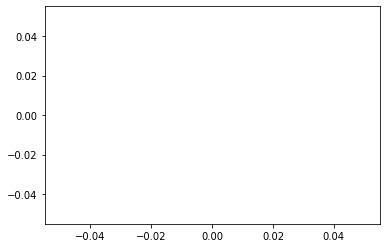

In [25]:
#winner
import torch, torch.nn as nn
import numpy as np
from egnn_pytorch import EGNN
from architecture import (StackedEGNN,
                          LearnableRBF,
                          AttentionBlock,
                          TunableBlock)
import time, datetime
import glob
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import random, os, numpy as np, torch, glob, datetime
from torch.cuda.amp import GradScaler, autocast

torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False


class Cfg(dict):
    # ================================================================
    # 0) dashboard – flip anything here
    # ================================================================
    __getattr__ = dict.__getitem__; __setattr__ = dict.__setitem__


# ================================================================
# 2) dataset helpers
# ================================================================
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader

# ================================================================
# 3) model
# ================================================================

class Model(nn.Module):
    "without knn = perm variant"
    def __init__(self,c):
        super().__init__(); self.c=c
        inner_dim = c.dim + c.basis

        self.egnn = StackedEGNN(c.dim,c.depth,c.hidden_dim,c.dropout,
                                c.hood_k,98,c.num_neighbors,c.norm_coors).to(c.device)

        self.rbf  = TunableBlock(LearnableRBF(c.basis,10.).to(c.device), c.use_rbf)
        self.attn = TunableBlock(AttentionBlock(inner_dim,inner_dim,c.hidden_dim).to(c.device), c.use_attn)

        if c.aggregator=='linear':
            self.agg = nn.Linear(inner_dim,1).to(c.device)
        elif c.aggregator=='nconv':
            self.agg = nn.Conv1d(c.hood_k,1,kernel_size=inner_dim,padding=0).to(c.device)
        elif c.aggregator=='pool':
            self.agg = None
        else: raise ValueError("aggregator must be 'linear' | 'nconv' | 'pool'")

        #
        self.boost = nn.Linear(1,1).to(c.device) if c.use_boost else nn.Identity()
        self.prot  = EGNN(dim=1,update_coors=True,norm_coors=True, norm_feats=True, 
                          num_nearest_neighbors=c.pegnn_radius).to(c.device) \
                     if c.use_prot else nn.Identity()
        self.rconv  = nn.Conv1d(1,1,c.conv_kernel,padding=c.conv_kernel//2).to(c.device) \
                     if c.use_conv else nn.Identity()

    def forward(self,z,x):
        h,coord=self.egnn(z,x); h=h[0]                # (R,N,dim)
        cent=coord.mean(1,keepdim=True)               # (R,1,3)

        # --- build token ----------------------------------------------------------------
        r = self.rbf(cent,coord).transpose(1,2) if self.c.use_rbf else \
            h.new_zeros(h.size(0),self.c.basis,self.c.hood_k)
        tok = torch.cat((r,h.transpose(1,2)),dim=1)       # (R,C,N)

        att = self.attn(tok.permute(2,0,1))
        tok = att[0] if isinstance(att,(tuple,list)) else att
        tok = tok.permute(1,0,2)                      # (R,N,C)

        # --- aggregation ----------------------------------------------------------------
        if self.c.aggregator=='linear':
            preds = self.agg(tok) .max(1).values                # (R,1)
        elif self.c.aggregator=='nconv':
            preds = self.agg(tok).squeeze(-1)                   # (R,1)
        else:   # pool
            preds = tok.max(1).values.mean(1,keepdim=True)      # (R,1)

        preds = self.boost(preds)

        if self.c.use_prot:
            preds = self.prot(preds.unsqueeze(0),
                              cent.permute(1,0,2))[0].squeeze(0)

        if self.c.use_conv:
            preds = self.rconv(preds.T.unsqueeze(0)).squeeze(0).T

        return preds
    
class HoodDS(Dataset):
    """Generate hoods around n_neighbors, a hyperparameter. This choice determines how many n_nearest neighbors
    the egnn encoder sees.
    
    This function takes as input the pdb.npz numpy files and returns an """
    def __init__(self, paths, keep_ids=False):
        self.data=[]; self.ids=[];self.keep_ids = keep_ids; 
        nbr=NearestNeighbors(n_neighbors=cfg.hood_k,algorithm='brute')
        for p in paths:
            try:
                d=np.load(p,allow_pickle=True)
                if len(d['sites'])==0: continue
                nbr.fit(d['pos']); idx=nbr.kneighbors(d['sites'],return_distance=False)
                self.data.append((torch.from_numpy(d['z'][idx]),
                                  torch.from_numpy(d['pos'][idx]),
                                  torch.from_numpy(d['pks'])))
                self.ids.append(os.path.splitext(os.path.basename(p))[0])
            except Exception as e: print("skip",p,e)
    def __len__(self): return len(self.data)
    def __getitem__(self,i):
        z,p,y=self.data[i]; 
        return z,p,y,self.ids[i] if self.keep_ids else z,p,y

    def pad(batch,k,device,keep_ids=False):
        ids=[b[3] for b in batch] if keep_ids else None
        B=len(batch); S=max(b[0].shape[0] for b in batch)
        zt=torch.zeros(B,S,k,dtype=torch.int32,device=device)
        pt=torch.zeros(B,S,k,3,dtype=torch.float32,device=device)
        yt=torch.full((B,S),float('nan'),device=device); mt=torch.zeros(B,S,dtype=torch.bool,device=device)
        for b,data in enumerate(batch):
            z,p,y=data[0],data[1],data[2]
            s=z.shape[0]; zt[b,:s]=z; pt[b,:s]=p; yt[b,:s]=y; mt[b,:s]=True
        return (zt,pt,yt,mt,data[3]) if keep_ids else (zt,pt,yt,mt)

    def split(paths):
        """deterministic and random"""
        if cfg.num_paths: paths=paths[:cfg.num_paths]
        #rng=np.random.RandomState(cfg.split_seed)
        #idx=rng.permutation(len(paths)); cut=int(len(paths)*cfg.split_ratio)
        cut=1
        idx=[0,1,2]
        return [paths[i] for i in idx[:cut]], [paths[i] for i in idx[cut:]]
# ================================================================
# 4) loaders
# ================================================================


def run_hoodDS(cfg):
    coll = lambda b: HoodDS.pad(b,cfg.hood_k,cfg.device,cfg.analysis_mode)
    tr,val=HoodDS.split(sorted(glob.glob(cfg.INPUTS_DIR)))
    train_ds=HoodDS(tr,cfg.hood_k); val_ds=HoodDS(val,cfg.hood_k)
    tr_loader=DataLoader(train_ds,batch_size=cfg.batch_size,shuffle=True , generator=g,collate_fn=coll); val_loader=DataLoader(val_ds,batch_size=cfg.batch_size,shuffle=False,collate_fn=coll)
    return tr_loader, val_loader

######################################################
t0=time.time()
cfg = Cfg(
    # backbone
    INPUTS_DIR="../../../data/pkegnn_INS/inputs/*.npz",
    dim=6, basis=6, depth=2, hidden_dim=4, dropout=0.00,
    hood_k=100, num_neighbors=11, norm_coors=True,

    epochs=1, num_paths=3,

    # aggregation: 'linear' | 'nconv' | 'pool'
    aggregator   ='nconv',

    # block switches
    use_rbf      =True,
    use_attn     =True,
    use_boost    =True,     # Linear(1→1) after aggregator
    use_prot     =True,      # protein‑level EGNN
    use_conv     =False,     # 1‑D conv after prot EGNN
    conv_kernel  =7,
    pegnn_radius=8, #so no idx error

    # training
    loss_type='mse',
    study_metrics=True,
    lr=5e-3, batch_size=1, #batchsize not safw to inc

    # misc
    device='cuda' if torch.cuda.is_available() else 'cpu',
    seed=0, analysis_mode=False,
    split_ratio=0.5, split_seed=0,
    runid=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
)
print("Run‑ID:", cfg.runid)
if not cfg.seed=="no seed":
    random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
    # 2) Create a fixed Generator for the train shuffle:
    g = torch.Generator()
    g.manual_seed(cfg.seed)

model=Model(cfg); 
print("params:",sum(p.numel() for p in model.parameters()))





# ================================================================
# 5) training utils
# ================================================================
tr_loader, va_loader=run_hoodDS(cfg)
p_fn = nn.L1Loss() if cfg.loss_type=='mae' else nn.MSELoss()
v_fn = nn.MSELoss() if cfg.loss_type=='mae' else nn.L1Loss()
opt  = torch.optim.AdamW(model.parameters(),lr=cfg.lr)
sch  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=0,cooldown=0,min_lr=1e-16)
scaler=GradScaler(enabled=(cfg.device=='cuda'))

def run(cfg, loader,train):
    model.train() if train else model.eval(); loss_sum=0;n=0;oloss_sum=0
    for z,x,y,m,*_ in loader:
        v=m.view(-1); z=z.view(-1,z.size(2))[v].to(cfg.device)
        x=x.view(-1,x.size(2),3)[v].to(cfg.device); y=y.view(-1)[v].to(cfg.device)
        with autocast(enabled=(cfg.device=='cuda')):
            pred=model(z,x).flatten(); loss=p_fn(pred,y)
        if train:
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        if cfg.study_metrics:
            other_loss = v_fn(pred,y)
            oloss_sum +=other_loss.item(); 
        loss_sum+=loss.item(); n+=1
        
    if not cfg.study_metrics:
        return loss_sum/n
    else:
        return (loss_sum/n, oloss_sum/n)

# ================================================================
# 6) train
# ================================================================
cfg.epochs=71
vl,tl=[],[]
for e in range(cfg.epochs):
    tr=run(cfg,tr_loader,True)
    va=run(cfg,va_loader,False)
    if not cfg.study_metrics:
        sch.step(va)
        print(f"[{e+1}/{cfg.epochs}]  train {tr:.4f} | val {va:.4f}")
        tl.append(va.item())
    else:
        sch.step(va[0])
        print(f"[{e+1}/{cfg.epochs}]  train {cfg.loss_type} {tr[0]:.4f} | {cfg.loss_type} val {va[0]:.4f}")
        print("     additional metrics: ",f"[{e+1}/{cfg.epochs}]  train {tr[1]:.4f} | val {va[1]:.4f}")
        print("")

print(time.time() - t0,"sec")

ckpt = {
    'model_state': model.state_dict(),
    'optim_state': opt.state_dict(),
    'sched_state': sch.state_dict(),
    'cfg'        : cfg,
}
ckpt_name = "ckpt_{}.pt".format(cfg['runid'])
#torch.save(ckpt, ckpt_name)
print("Saved checkpoint:", ckpt_name)

# ---------- run the suite on real inputs -------------------------------------
print("\n================  INVARIANCE SUITE  ================\n")
stats = run_invariance_suite(model, tr_loader, cfg,
                            max_batches=3, rot_trials=5,
                            atol=5e-4, rtol=5e-4, verbose=True)

print("\n----------------  summary (max abs error) ----------------")
for k,v in stats.items():
    print(f"{k:6}: {v:.3e}")
print("----------------------------------------------------------")
print("✔  thresholds used: atol={:.1e}, rtol={:.1e}".format(5e-4,5e-4))
print("==========================================================\n")
from matplotlib import pyplot as plt
plt.plot(tl)

In [ ]:
# ================================================================
# 7)  SE(3)‑equivariance & permutation‑invariance checker
# ================================================================
import torch, math, itertools, random
from collections import defaultdict
torch.set_printoptions(precision=3, sci_mode=True)

# ---------- helpers ----------------------------------------------------------
def _random_rotation(device):
    """Draw a random 3×3 rotation matrix from a unit quaternion."""
    q = torch.randn(4, device=device); q /= q.norm()
    w, x, y, z = q
    return torch.tensor([[1-2*(y*y+z*z), 2*(x*y - z*w), 2*(x*z + y*w)],
                         [2*(x*y + z*w), 1-2*(x*x+z*z), 2*(y*z - x*w)],
                         [2*(x*z - y*w), 2*(y*z + x*w), 1-2*(x*x+y*y)]],
                        device=device)

def _prep_batch(batch, cfg):
    """Flatten (B,S,K,…) → (R,K,…) and drop padded rows."""
    z, x, _, m, *_ = batch
    mask  = m.view(-1)                             # (R,)
    z = z.view(-1, z.size(2))[mask].to(cfg.device)           # (R,K)
    x = x.view(-1, x.size(2), 3)[mask].to(cfg.device)        # (R,K,3)
    return z, x                                     # R = Σ valid residues

# ---------- core checks ------------------------------------------------------
@torch.no_grad()
def run_invariance_suite(model, loader, cfg,
                         max_batches=4, rot_trials=3,
                         atol=5e-4, rtol=5e-4, verbose=True):
    """
    For `max_batches` mini‑batches:
      • SE(3) equivariance   (rot + trans)
      • neighbour perm‑inv   (perm K)
      • residue  perm‑eqv    (perm R)
    Returns dict with max abs‑errors.
    """
    stats = defaultdict(float)
    model.eval()

    for b_id, batch in enumerate(loader):
        if b_id >= max_batches: break
        z, x = _prep_batch(batch, cfg)             # (R,K), (R,K,3)

        # --- baseline prediction -------------------------------------------------
        base = model(z, x).flatten()               # (R,)

        # -- 1) SE(3) equivariance -----------------------------------------------
        for t in range(rot_trials):
            R = _random_rotation(x.device)
            tvec = torch.randn(1,1,3, device=x.device)
            x_rt = (x @ R.T) + tvec
            p_rt = model(z, x_rt).flatten()
            err  = (base - p_rt).abs().max().item()
            stats['eqv'] = max(stats['eqv'], err)
            if verbose:
                print(f"[batch {b_id}  rot {t}]  max|Δ|={err:.3e}")

        # -- 2) neighbour‑perm invariance ----------------------------------------
        K = z.size(1)
        permK = torch.randperm(K, device=x.device)
        pK = model(z[:, permK], x[:, permK]).flatten()
        errK = (base - pK).abs().max().item()
        stats['permK'] = max(stats['permK'], errK)
        if verbose:
            print(f"[batch {b_id}  perm‑K ]  max|Δ|={errK:.3e}")

        # -- 3) residue‑perm equivariance ----------------------------------------
        Rn = z.size(0)
        permR = torch.randperm(Rn, device=x.device)
        zR, xR  = z[permR], x[permR]
        pR = model(zR, xR).flatten()
        # undo permutation on prediction
        pR = pR[permR.argsort()]
        errR = (base - pR).abs().max().item()
        stats['permR'] = max(stats['permR'], errR)
        if verbose:
            print(f"[batch {b_id}  perm‑R ]  max|Δ|={errR:.3e}")
            print("-"*55)

    return stats


import torch, torch.nn as nn
import numpy as np
from egnn_pytorch import EGNN
from architecture import (StackedEGNN,
                          LearnableRBF,
                          AttentionBlock,
                          TunableBlock)
import time, datetime
import glob
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import random, os, numpy as np, torch, glob, datetime
from torch.cuda.amp import GradScaler, autocast

torch.backends.cudnn.deterministic=True; torch.backends.cudnn.benchmark=False


class Cfg(dict):
    # ================================================================
    # 0) dashboard – flip anything here
    # ================================================================
    __getattr__ = dict.__getitem__; __setattr__ = dict.__setitem__


# ================================================================
# 2) dataset helpers
# ================================================================
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader

# ================================================================
# 3) model
# ================================================================

class Model(nn.Module):
    "without knn = perm variant"
    def __init__(self,c):
        super().__init__(); self.c=c
        inner_dim = c.dim + c.basis

        self.egnn = StackedEGNN(c.dim,c.depth,c.hidden_dim,c.dropout,
                                c.hood_k,98,c.num_neighbors,c.norm_coors).to(c.device)

        self.rbf  = TunableBlock(LearnableRBF(c.basis,10.).to(c.device), c.use_rbf)
        self.attn = TunableBlock(AttentionBlock(inner_dim,inner_dim,c.hidden_dim).to(c.device), c.use_attn)

        if c.aggregator=='linear':
            self.agg = nn.Linear(inner_dim,1).to(c.device)
        elif c.aggregator=='nconv':
            self.agg = nn.Conv1d(c.hood_k,1,kernel_size=inner_dim,padding=0).to(c.device)
        elif c.aggregator=='pool':
            self.agg = None
        else: raise ValueError("aggregator must be 'linear' | 'nconv' | 'pool'")

        #
        self.boost = nn.Linear(1,1).to(c.device) if c.use_boost else nn.Identity()
        self.prot  = EGNN(dim=1,update_coors=True,norm_coors=True, norm_feats=True, 
                          num_nearest_neighbors=c.pegnn_radius).to(c.device) \
                     if c.use_prot else nn.Identity()
        self.rconv  = nn.Conv1d(1,1,c.conv_kernel,padding=c.conv_kernel//2).to(c.device) \
                     if c.use_conv else nn.Identity()

    def forward(self,z,x):
        h,coord=self.egnn(z,x); h=h[0]                # (R,N,dim)
        cent=coord.mean(1,keepdim=True)               # (R,1,3)

        # --- build token ----------------------------------------------------------------
        r = self.rbf(cent,coord).transpose(1,2) if self.c.use_rbf else \
            h.new_zeros(h.size(0),self.c.basis,self.c.hood_k)
        tok = torch.cat((r,h.transpose(1,2)),dim=1)       # (R,C,N)

        att = self.attn(tok.permute(2,0,1))
        tok = att[0] if isinstance(att,(tuple,list)) else att
        tok = tok.permute(1,0,2)                      # (R,N,C)

        # --- aggregation ----------------------------------------------------------------
        if self.c.aggregator=='linear':
            preds = self.agg(tok) .max(1).values                # (R,1)
        elif self.c.aggregator=='nconv':
            preds = self.agg(tok).squeeze(-1)                   # (R,1)
        else:   # pool
            preds = tok.max(1).values.mean(1,keepdim=True)      # (R,1)

        preds = self.boost(preds)

        if self.c.use_prot:
            preds = self.prot(preds.unsqueeze(0),
                              cent.permute(1,0,2))[0].squeeze(0)

        if self.c.use_conv:
            preds = self.rconv(preds.T.unsqueeze(0)).squeeze(0).T

        return preds
    
class HoodDS(Dataset):
    """Generate hoods around n_neighbors, a hyperparameter. This choice determines how many n_nearest neighbors
    the egnn encoder sees.
    
    This function takes as input the pdb.npz numpy files and returns an """
    def __init__(self, paths, keep_ids=False):
        self.data=[]; self.ids=[];self.keep_ids = keep_ids; 
        nbr=NearestNeighbors(n_neighbors=cfg.hood_k,algorithm='brute')
        for p in paths:
            try:
                d=np.load(p,allow_pickle=True)
                if len(d['sites'])==0: continue
                nbr.fit(d['pos']); idx=nbr.kneighbors(d['sites'],return_distance=False)
                self.data.append((torch.from_numpy(d['z'][idx]),
                                  torch.from_numpy(d['pos'][idx]),
                                  torch.from_numpy(d['pks'])))
                self.ids.append(os.path.splitext(os.path.basename(p))[0])
            except Exception as e: print("skip",p,e)
    def __len__(self): return len(self.data)
    def __getitem__(self,i):
        z,p,y=self.data[i]; 
        return z,p,y,self.ids[i] if self.keep_ids else z,p,y

    def pad(batch,k,device,keep_ids=False):
        ids=[b[3] for b in batch] if keep_ids else None
        B=len(batch); S=max(b[0].shape[0] for b in batch)
        zt=torch.zeros(B,S,k,dtype=torch.int32,device=device)
        pt=torch.zeros(B,S,k,3,dtype=torch.float32,device=device)
        yt=torch.full((B,S),float('nan'),device=device); mt=torch.zeros(B,S,dtype=torch.bool,device=device)
        for b,data in enumerate(batch):
            z,p,y=data[0],data[1],data[2]
            s=z.shape[0]; zt[b,:s]=z; pt[b,:s]=p; yt[b,:s]=y; mt[b,:s]=True
        return (zt,pt,yt,mt,data[3]) if keep_ids else (zt,pt,yt,mt)

    def split(paths):
        """deterministic and random"""
        if cfg.num_paths: paths=paths[:cfg.num_paths]
        #rng=np.random.RandomState(cfg.split_seed)
        #idx=rng.permutation(len(paths)); cut=int(len(paths)*cfg.split_ratio)
        cut=1
        idx=[0,1,2]
        return [paths[i] for i in idx[:cut]], [paths[i] for i in idx[cut:]]
# ================================================================
# 4) loaders
# ================================================================


def run_hoodDS(cfg):
    coll = lambda b: HoodDS.pad(b,cfg.hood_k,cfg.device,cfg.analysis_mode)
    tr,val=HoodDS.split(sorted(glob.glob(cfg.INPUTS_DIR)))
    train_ds=HoodDS(tr,cfg.hood_k); val_ds=HoodDS(val,cfg.hood_k)
    tr_loader=DataLoader(train_ds,batch_size=cfg.batch_size,shuffle=True , generator=g,collate_fn=coll); val_loader=DataLoader(val_ds,batch_size=cfg.batch_size,shuffle=False,collate_fn=coll)
    return tr_loader, val_loader

######################################################
t0=time.time()
cfg = Cfg(
    # backbone
    INPUTS_DIR="../../../data/pkegnn_INS/inputs/*.npz",
    dim=6, basis=6, depth=2, hidden_dim=4, dropout=0.00,
    hood_k=100, num_neighbors=11, norm_coors=True,

    epochs=1, num_paths=3,

    # aggregation: 'linear' | 'nconv' | 'pool'
    aggregator   ='nconv',

    # block switches
    use_rbf      =True,
    use_attn     =False,
    use_boost    =True,     # Linear(1→1) after aggregator
    use_prot     =True,      # protein‑level EGNN
    use_conv     =False,     # 1‑D conv after prot EGNN
    conv_kernel  =7,
    pegnn_radius=8, #so no idx error

    # training
    loss_type='mse',
    study_metrics=True,
    lr=5e-3, batch_size=1, #batchsize not safw to inc

    # misc
    device='cuda' if torch.cuda.is_available() else 'cpu',
    seed=0, analysis_mode=False,
    split_ratio=0.5, split_seed=0,
    runid=datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
)
print("Run‑ID:", cfg.runid)
if not cfg.seed=="no seed":
    random.seed(cfg.seed); np.random.seed(cfg.seed); torch.manual_seed(cfg.seed)
    # 2) Create a fixed Generator for the train shuffle:
    g = torch.Generator()
    g.manual_seed(cfg.seed)

model=Model(cfg); 
print("params:",sum(p.numel() for p in model.parameters()))





# ================================================================
# 5) training utils
# ================================================================
tr_loader, va_loader=run_hoodDS(cfg)
p_fn = nn.L1Loss() if cfg.loss_type=='mae' else nn.MSELoss()
v_fn = nn.MSELoss() if cfg.loss_type=='mae' else nn.L1Loss()
opt  = torch.optim.AdamW(model.parameters(),lr=cfg.lr)
sch  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=0,cooldown=0,min_lr=1e-16)
scaler=GradScaler(enabled=(cfg.device=='cuda'))

def run(cfg, loader,train):
    model.train() if train else model.eval(); loss_sum=0;n=0;oloss_sum=0
    for z,x,y,m,*_ in loader:
        v=m.view(-1); z=z.view(-1,z.size(2))[v].to(cfg.device)
        x=x.view(-1,x.size(2),3)[v].to(cfg.device); y=y.view(-1)[v].to(cfg.device)
        with autocast(enabled=(cfg.device=='cuda')):
            pred=model(z,x).flatten(); loss=p_fn(pred,y)
        if train:
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        if cfg.study_metrics:
            other_loss = v_fn(pred,y)
            oloss_sum +=other_loss.item(); 
        loss_sum+=loss.item(); n+=1
        
    if not cfg.study_metrics:
        return loss_sum/n
    else:
        return (loss_sum/n, oloss_sum/n)

# ================================================================
# 6) train
# ================================================================
cfg.epochs=71
for e in range(cfg.epochs):
    vl,tl=[],[]
    tr=run(cfg,tr_loader,True)
    va=run(cfg,va_loader,False)
    if not cfg.study_metrics:
        sch.step(va)
        print(f"[{e+1}/{cfg.epochs}]  train {tr:.4f} | val {va:.4f}")
        tl.append(va.item())
    else:
        sch.step(va[0])
        print(f"[{e+1}/{cfg.epochs}]  train {cfg.loss_type} {tr[0]:.4f} | {cfg.loss_type} val {va[0]:.4f}")
        print("     additional metrics: ",f"[{e+1}/{cfg.epochs}]  train {tr[1]:.4f} | val {va[1]:.4f}")
        print("")

print(time.time() - t0,"sec")

ckpt = {
    'model_state': model.state_dict(),
    'optim_state': opt.state_dict(),
    'sched_state': sch.state_dict(),
    'cfg'        : cfg,
}
ckpt_name = "ckpt_{}.pt".format(cfg['runid'])
#torch.save(ckpt, ckpt_name)
print("Saved checkpoint:", ckpt_name)

# ---------- run the suite on real inputs -------------------------------------
print("\n================  INVARIANCE SUITE  ================\n")
stats = run_invariance_suite(model, tr_loader, cfg,
                            max_batches=3, rot_trials=5,
                            atol=5e-4, rtol=5e-4, verbose=True)

print("\n----------------  summary (max abs error) ----------------")
for k,v in stats.items():
    print(f"{k:6}: {v:.3e}")
print("----------------------------------------------------------")
print("✔  thresholds used: atol={:.1e}, rtol={:.1e}".format(5e-4,5e-4))
print("==========================================================\n")
from matplotlib import pyplot as plt
plt.plot(tl)
plt.show()


================  INVARIANCE SUITE  ================

[batch 0  rot 0]  max|Δ|=1.788e-07
[batch 0  rot 1]  max|Δ|=3.278e-07
[batch 0  rot 2]  max|Δ|=2.384e-07
[batch 0  rot 3]  max|Δ|=2.682e-07
[batch 0  rot 4]  max|Δ|=5.662e-07
[batch 0  perm‑K ]  max|Δ|=5.273e-02
[batch 0  perm‑R ]  max|Δ|=7.631e-01
-------------------------------------------------------

----------------  summary (max abs error) ----------------
eqv   : 5.662e-07
permK : 5.273e-02
permR : 7.631e-01
----------------------------------------------------------
✔  thresholds used: atol=5.0e-04, rtol=5.0e-04



NameError: name 'z' is not defined

In [3]:
#glob.glob(cfg.INPUTS_DIR)# At the very top of your script, before ANY other imports:
import os
import glob
# fix Python hash seed
os.environ["PYTHONHASHSEED"] = "0"
# single‑thread BLAS (optional but safer)
os.environ["OMP_NUM_THREADS"]       = "1"
os.environ["OPENBLAS_NUM_THREADS"]  = "1"
os.environ["MKL_NUM_THREADS"]       = "1"
os.environ["TORCH_NUM_THREADS"]     = "1"

import random, numpy as np, torch

# global seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# enforce pure‑Python determinism in PyTorch
torch.use_deterministic_algorithms(True)

# now your other imports...
from sklearn.neighbors import NearestNeighbors
# …



In [4]:
cfg.hood_k

100